In [1]:
!pip install PyWavelets
!pip install openTSNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.9 MB/s eta 0:00:00


In [2]:
import pywt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from openTSNE import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from sklearn.utils import resample
from scipy.stats import skew, kurtosis

In [3]:
# Set global random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# Load dataset
file_path = "/content/Epileptic Seizure Recognition.csv"  # Update path if needed
df = pd.read_csv(file_path)

In [5]:
# Drop unnecessary columns (if any)
df = df.drop(columns=['Unnamed'], errors='ignore')

# Ensure target labels start from 0 (assuming 1-based indexing)
df['y'] = df['y'] - 1

# Check initial class distribution
print("Original Class Distribution:\n", df['y'].value_counts())

Original Class Distribution:
 y
3    2300
0    2300
4    2300
1    2300
2    2300
Name: count, dtype: int64


In [6]:
print(df.describe())

                 X1            X2            X3            X4            X5  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean     -11.581391    -10.911565    -10.187130     -9.143043     -8.009739   
std      165.626284    166.059609    163.524317    161.269041    160.998007   
min    -1839.000000  -1838.000000  -1835.000000  -1845.000000  -1791.000000   
25%      -54.000000    -55.000000    -54.000000    -54.000000    -54.000000   
50%       -8.000000     -8.000000     -7.000000     -8.000000     -8.000000   
75%       34.000000     35.000000     36.000000     36.000000     35.000000   
max     1726.000000   1713.000000   1697.000000   1612.000000   1518.000000   

                 X6            X7           X8           X9           X10  \
count  11500.000000  11500.000000  11500.00000  11500.00000  11500.000000   
mean      -7.003478     -6.502087     -6.68713     -6.55800     -6.168435   
std      161.328725    161.467837    162.11912    162.033

In [7]:
# Separate features and target variable
X = df.drop(columns=['y'])  # Features
y = df['y']  # Target

# Define SMOTE for class 0 only (since you subtracted 1 from 'y', class 1 is now class 0)
smote = SMOTE(sampling_strategy={0: 9200}, random_state=42)

# Apply SMOTE only on class 0
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled data
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['y'])], axis=1)

# Check new class distribution
print("Class distribution after SMOTE:\n", df_resampled['y'].value_counts())

# Save the new dataset
df_resampled.to_csv("/content/Epileptic_Seizure_Recognition_SMOTED.csv", index=False)
print("Resampled dataset saved successfully!")

Class distribution after SMOTE:
 y
0    9200
3    2300
4    2300
1    2300
2    2300
Name: count, dtype: int64
Resampled dataset saved successfully!


Categorized Feature Correlations:
      Feature 1 Feature 2  Correlation                     Category
2328        X14       X15     0.950880  Strong Positive Correlation
2505        X15       X14     0.950880  Strong Positive Correlation
2507        X15       X16     0.949805  Strong Positive Correlation
2684        X16       X15     0.949805  Strong Positive Correlation
20584      X116      X115     0.948074  Strong Positive Correlation
...         ...       ...          ...                          ...
7858        X45       X27    -0.206563    Weak Negative Correlation
30950      X174      X157    -0.208016    Weak Negative Correlation
27941      X157      X174    -0.208016    Weak Negative Correlation
27942      X157      X175    -0.210484    Weak Negative Correlation
31128      X175      X157    -0.210484    Weak Negative Correlation

[31506 rows x 4 columns]
Correlation Category Counts:
Category
Weak Positive Correlation      18340
Weak Negative Correlation      12788
Strong Posit

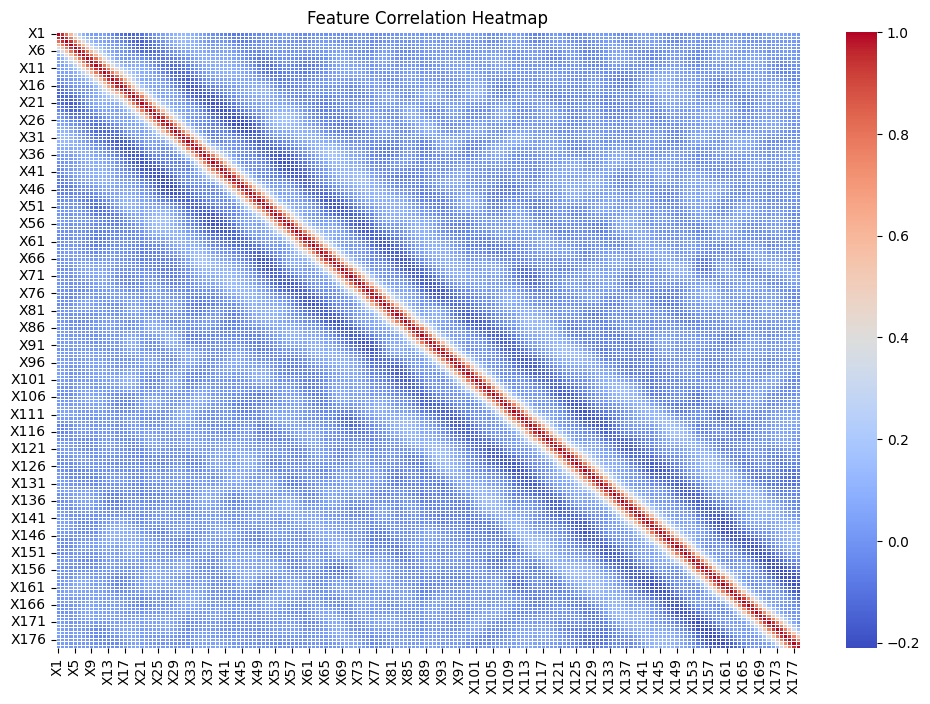

In [8]:
# Compute correlation matrix
correlation_matrix = df.drop(columns=['y']).corr()

# Define correlation categories
def categorize_correlation(value):
    if value >= 0.8:
        return "Strong Positive Correlation"
    elif 0 < value < 0.8:
        return "Weak Positive Correlation"
    elif value == 0:
        return "No Correlation"
    elif -0.8 < value < 0:
        return "Weak Negative Correlation"
    elif value <= -0.8:
        return "Strong Negative Correlation"

# Flatten the correlation matrix and categorize relationships
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlation_pairs = correlation_pairs[correlation_pairs['Feature 1'] != correlation_pairs['Feature 2']]  # Remove self-correlation
correlation_pairs['Category'] = correlation_pairs['Correlation'].apply(categorize_correlation)

# Display categorized correlations
print("Categorized Feature Correlations:")
print(correlation_pairs.sort_values(by="Correlation", ascending=False))

# Count the number of occurrences in each category
category_counts = correlation_pairs['Category'].value_counts()

# Print the results
print("Correlation Category Counts:")
print(category_counts)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
df = pd.read_csv("/content/Epileptic_Seizure_Recognition_SMOTED.csv")

X = df.iloc[:, :-1]  # All columns except the last (features)
y = df.iloc[:, -1]   # Last column (labels)

# Function to apply DWT and extract statistical features
def extract_dwt_features(signal, wavelet='db4', level=4):
    """
    Apply Discrete Wavelet Transform (DWT) to an EEG signal and extract advanced statistical features.
    """
    # Perform DWT decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Extract required coefficients
    A5 = coeffs[0]  # Approximation (Low-frequency)
    D5, D4, D3 = coeffs[1:4]  # Detail coefficients (High-frequency)

    # Compute Statistical Features
    features = {
        # Basic Features
        'A5_mean': np.mean(A5), 'A5_power': np.sum(np.square(A5)), 'A5_std': np.std(A5),
        'D5_mean': np.mean(D5), 'D5_power': np.sum(np.square(D5)), 'D5_std': np.std(D5),
        'D4_mean': np.mean(D4), 'D4_power': np.sum(np.square(D4)), 'D4_std': np.std(D4),
        'D3_mean': np.mean(D3), 'D3_power': np.sum(np.square(D3)), 'D3_std': np.std(D3),

        # Ratio of Mean Values
        'ratio_A5_D5': np.mean(A5) / (np.mean(D5) + 1e-6),
        'ratio_D5_D4': np.mean(D5) / (np.mean(D4) + 1e-6),
        'ratio_D4_D3': np.mean(D4) / (np.mean(D3) + 1e-6),

        # New Features: Higher-Order Moments
        'A5_skew': skew(A5), 'A5_kurtosis': kurtosis(A5),
        'D5_skew': skew(D5), 'D5_kurtosis': kurtosis(D5),
        'D4_skew': skew(D4), 'D4_kurtosis': kurtosis(D4),
        'D3_skew': skew(D3), 'D3_kurtosis': kurtosis(D3),

        # New Features: Entropy
        'A5_entropy': -np.sum(A5 * np.log2(np.abs(A5) + 1e-6)),
        'D5_entropy': -np.sum(D5 * np.log2(np.abs(D5) + 1e-6)),
        'D4_entropy': -np.sum(D4 * np.log2(np.abs(D4) + 1e-6)),
        'D3_entropy': -np.sum(D3 * np.log2(np.abs(D3) + 1e-6)),

        'A5_log_energy': np.log(np.sum(np.square(A5)) + 1e-6),
        'D5_log_energy': np.log(np.sum(np.square(D5)) + 1e-6),
        'D4_log_energy': np.log(np.sum(np.square(D4)) + 1e-6),
        'D3_log_energy': np.log(np.sum(np.square(D3)) + 1e-6),
    }

    return features

# Apply DWT to each EEG signal in the dataset
dwt_features = X.apply(lambda row: extract_dwt_features(row.values), axis=1)

# Convert dictionary results into a DataFrame
dwt_features_df = pd.DataFrame(list(dwt_features))

# Combine extracted features with target labels
df_final = pd.concat([dwt_features_df, y], axis=1)

# Save new dataset with DWT features
df_final.to_csv("/content/EEG_DWT_Enhanced_Features.csv", index=False)

# Check new feature dataset
print("Transformed Dataset with Enhanced DWT Features:\n", df_final.head())

Transformed Dataset with Enhanced DWT Features:
       A5_mean      A5_power       A5_std     D5_mean      D5_power  \
0  168.657765  3.690802e+06   434.350715   42.936816  1.535263e+05   
1  526.897609  2.982845e+07  1215.316304 -140.260084  1.164573e+07   
2 -165.463089  5.954840e+05    87.466787  -31.466787  9.436542e+04   
3 -309.218794  1.686014e+06    59.674572    8.360773  1.825810e+04   
4 -114.470121  5.950417e+05   147.983260  -16.875378  5.298987e+04   

       D5_std    D4_mean      D4_power      D4_std   D3_mean  ...  \
0   84.778474 -12.561747  7.258087e+05  160.511501 -2.402470  ...   
1  815.702345 -27.645650  6.569807e+06  483.602828 -2.017246  ...   
2   67.533312   4.478563  1.429052e+05   71.300071  0.780369  ...   
3   31.687591   3.092194  1.450674e+04   22.550748 -0.386250  ...   
4   53.219103  -5.755093  7.528144e+04   51.531562  1.352887  ...   

   D3_kurtosis    A5_entropy    D5_entropy   D4_entropy   D3_entropy  \
0     0.027671 -29295.887417  -5246.968570 

In [10]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First few rows of X:\n", X.head())
print("First few labels in y:\n", y.head())

X shape: (18400, 178)
y shape: (18400,)
First few rows of X:
     X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X169  X170  X171  \
0  135  190  229  223  192  125   55   -9  -33  -38  ...     8   -17   -15   
1  386  382  356  331  320  315  307  272  244  232  ...   168   164   150   
2  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  ...    29    57    64   
3 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  ...   -80   -82   -81   
4   -9  -65  -98 -102  -78  -48  -16    0  -21  -59  ...    10     4     2   

   X172  X173  X174  X175  X176  X177  X178  
0   -31   -77  -103  -127  -116   -83   -51  
1   146   152   157   156   154   143   129  
2    48    19   -12   -30   -35   -35   -36  
3   -80   -77   -85   -77   -72   -69   -65  
4   -12   -32   -41   -65   -83   -89   -73  

[5 rows x 178 columns]
First few labels in y:
 0    3
1    0
2    4
3    4
4    4
Name: y, dtype: int64


In [11]:
# Load the transformed dataset with DWT features
df_dwt = pd.read_csv("/content/EEG_DWT_Enhanced_Features.csv")

# Separate features and labels
X_dwt = df_dwt.iloc[:, :-1]  # All feature columns
y_dwt = df_dwt.iloc[:, -1]   # Target labels

# Standardize the features for better clustering performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dwt)

# Apply K-Means Clustering
k = 5  # Number of clusters as per base paper
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels as a new feature
df_dwt["KMeans_Cluster"] = cluster_labels

# Save the new dataset with K-Means features
df_dwt.to_csv("/content/EEG_DWT_KMeans_Features.csv", index=False)

# Display first few rows
print("Dataset with K-Means Cluster Labels:\n", df_dwt.head())

Dataset with K-Means Cluster Labels:
       A5_mean      A5_power       A5_std     D5_mean      D5_power  \
0  168.657765  3.690802e+06   434.350715   42.936816  1.535263e+05   
1  526.897609  2.982845e+07  1215.316304 -140.260084  1.164573e+07   
2 -165.463089  5.954840e+05    87.466787  -31.466787  9.436542e+04   
3 -309.218794  1.686014e+06    59.674572    8.360773  1.825810e+04   
4 -114.470121  5.950417e+05   147.983260  -16.875378  5.298987e+04   

       D5_std    D4_mean      D4_power      D4_std   D3_mean  ...  \
0   84.778474 -12.561747  7.258087e+05  160.511501 -2.402470  ...   
1  815.702345 -27.645650  6.569807e+06  483.602828 -2.017246  ...   
2   67.533312   4.478563  1.429052e+05   71.300071  0.780369  ...   
3   31.687591   3.092194  1.450674e+04   22.550748 -0.386250  ...   
4   53.219103  -5.755093  7.528144e+04   51.531562  1.352887  ...   

     A5_entropy    D5_entropy   D4_entropy   D3_entropy  A5_log_energy  \
0 -29295.887417  -5246.968570  2925.031397   720.254

Explained Variance Ratio for Each Principal Component:
PC1: 0.8235 (82.35% cumulative)
PC2: 0.1201 (94.35% cumulative)
PC3: 0.0554 (99.90% cumulative)
PC4: 0.0010 (100.00% cumulative)
PC5: 0.0000 (100.00% cumulative)
PC6: 0.0000 (100.00% cumulative)
PC7: 0.0000 (100.00% cumulative)
PC8: 0.0000 (100.00% cumulative)
PC9: 0.0000 (100.00% cumulative)
PC10: 0.0000 (100.00% cumulative)
PC11: 0.0000 (100.00% cumulative)
PC12: 0.0000 (100.00% cumulative)
PC13: 0.0000 (100.00% cumulative)
PC14: 0.0000 (100.00% cumulative)
PC15: 0.0000 (100.00% cumulative)
PC16: 0.0000 (100.00% cumulative)
PC17: 0.0000 (100.00% cumulative)
PC18: 0.0000 (100.00% cumulative)
PC19: 0.0000 (100.00% cumulative)
PC20: 0.0000 (100.00% cumulative)
PC21: 0.0000 (100.00% cumulative)
PC22: 0.0000 (100.00% cumulative)
PC23: 0.0000 (100.00% cumulative)
PC24: 0.0000 (100.00% cumulative)
PC25: 0.0000 (100.00% cumulative)
PC26: 0.0000 (100.00% cumulative)
PC27: 0.0000 (100.00% cumulative)
PC28: 0.0000 (100.00% cumulative)
PC29:

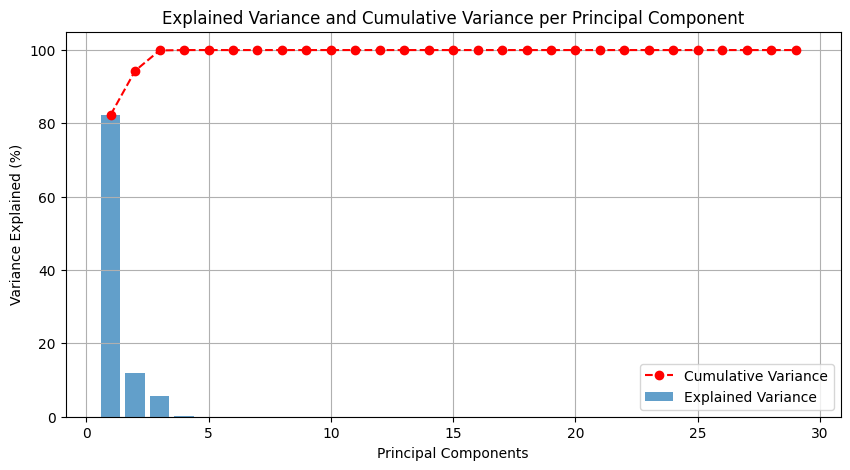

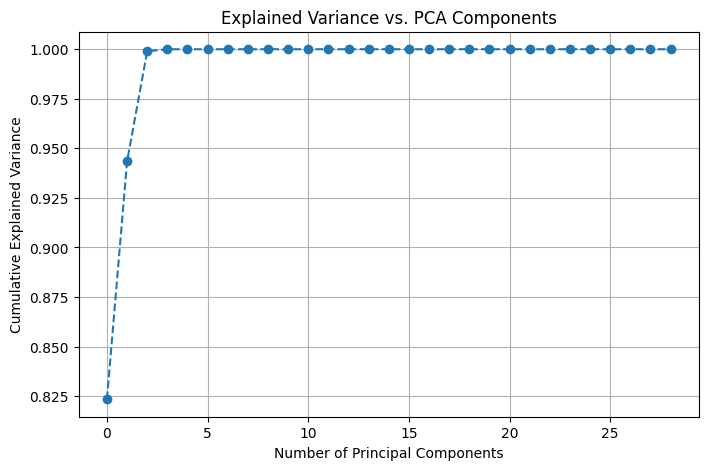

In [ ]:
df = pd.read_csv("/content/EEG_DWT_KMeans_Features.csv")

# Separate features and target variable
X_dwt = df.drop(columns=['KMeans_Cluster', 'y'])  # Features

pca = PCA(n_components=29)
X_pca_transformed = pca.fit_transform(X_dwt)

# Convert the PCA-transformed data into a DataFrame
df_pca_final = pd.DataFrame(X_pca_transformed, columns=[f'PC{i+1}' for i in range(29)])
df_pca_final['KMeans_Cluster'] = y_dwt  # Add the target variable back

# Save the PCA-transformed dataset
df_pca_final.to_csv("/content/EEG_DWT_PCA_29_Features.csv", index=False)

# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print variance details
print("Explained Variance Ratio for Each Principal Component:")
for i, var in enumerate(explained_variance, 1):
    print(f"PC{i}: {var:.4f} ({cumulative_variance[i-1]*100:.2f}% cumulative)")

# Total variance retained
print(f"\nTotal Variance Retained with 29 Components: {cumulative_variance[-1] * 100:.2f}%")

# Plot explained variance per component


plt.figure(figsize=(10, 5))
plt.bar(range(1, 30), explained_variance * 100, alpha=0.7, label="Explained Variance")
plt.plot(range(1, 30), cumulative_variance * 100, marker='o', linestyle='--', color='r', label="Cumulative Variance")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance and Cumulative Variance per Principal Component")
plt.legend()
plt.grid(True)
plt.show()

# Plot explained variance ratio
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. PCA Components')
plt.grid()
plt.show()



                PC1           PC2           PC3           PC4            PC5  \
0     -3.664007e+06 -1.469066e+06 -1.033382e+06 -4.369120e+04  -35503.516373   
1      2.524132e+07  6.534351e+04  2.767300e+06  1.298175e+06 -105803.019507   
2     -6.715284e+06 -9.162802e+05 -4.716704e+05 -1.929277e+04   16306.672844   
3     -5.746529e+06 -1.429853e+06 -5.695067e+05 -1.800623e+04   37933.278229   
4     -6.741798e+06 -9.874774e+05 -4.729365e+05  1.029777e+04   10553.964614   
...             ...           ...           ...           ...            ...   
18395 -5.233329e+06 -9.650302e+05 -7.835791e+04 -5.336393e+03    3577.249873   
18396 -6.200514e+06 -8.995905e+05 -4.299664e+05  8.646934e+03   19211.160525   
18397 -3.569262e+06 -9.625889e+05 -4.249051e+05  2.763180e+04  -18804.242589   
18398 -7.601031e+05 -3.115514e+06 -1.027920e+06 -3.675439e+04  -14455.815646   
18399  7.326518e+05 -3.271112e+06 -9.401913e+05 -4.085499e+04   33246.296642   

                PC6          PC7       

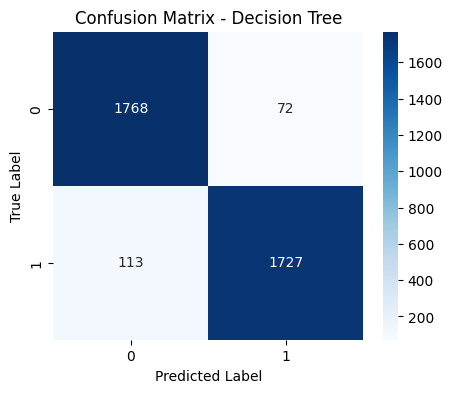

Training Random Forest...

Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Training Accuracy: 1.0000
Random Forest Testing Accuracy: 0.9644
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1840
           1       0.97      0.96      0.96      1840

    accuracy                           0.96      3680
   macro avg       0.96      0.96      0.96      3680
weighted avg       0.96      0.96      0.96      3680



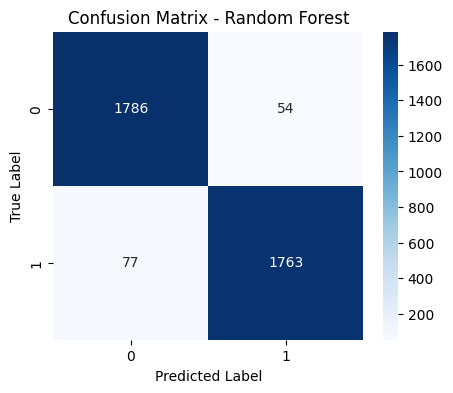

Training KNN...

KNN Best Params: {'n_neighbors': 7, 'weights': 'distance'}
KNN Training Accuracy: 1.0000
KNN Testing Accuracy: 0.9625
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1840
           1       0.97      0.95      0.96      1840

    accuracy                           0.96      3680
   macro avg       0.96      0.96      0.96      3680
weighted avg       0.96      0.96      0.96      3680



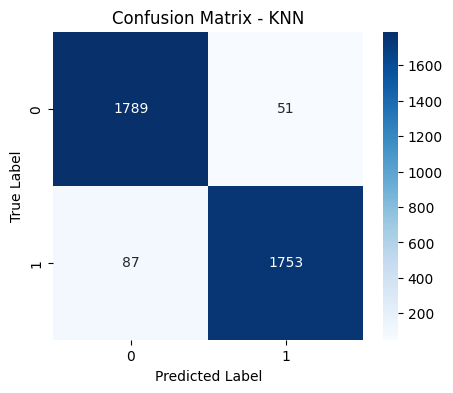

Training XGBoost...

XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGBoost Training Accuracy: 1.0000
XGBoost Testing Accuracy: 0.9739
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1840
           1       0.98      0.97      0.97      1840

    accuracy                           0.97      3680
   macro avg       0.97      0.97      0.97      3680
weighted avg       0.97      0.97      0.97      3680



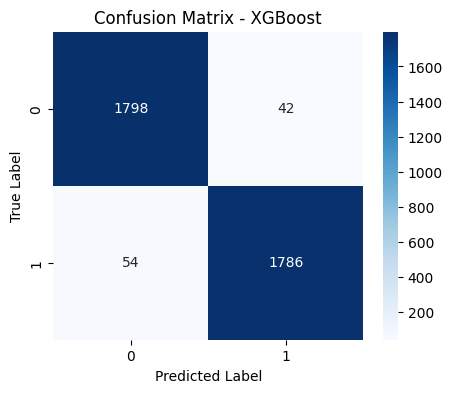

Training MLP...

MLP Best Params: {'hidden_layer_sizes': (128, 64), 'max_iter': 500}
MLP Training Accuracy: 0.9606
MLP Testing Accuracy: 0.9565
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1840
           1       0.94      0.98      0.96      1840

    accuracy                           0.96      3680
   macro avg       0.96      0.96      0.96      3680
weighted avg       0.96      0.96      0.96      3680



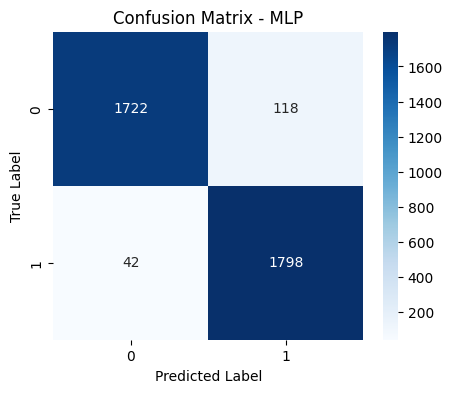


 Model Performance Comparison(PCA + K-MEANS)
Decision Tree: Training Accuracy = 0.9860, Testing Accuracy = 0.9497
Random Forest: Training Accuracy = 1.0000, Testing Accuracy = 0.9644
KNN: Training Accuracy = 1.0000, Testing Accuracy = 0.9625
XGBoost: Training Accuracy = 1.0000, Testing Accuracy = 0.9739
MLP: Training Accuracy = 0.9606, Testing Accuracy = 0.9565


In [13]:
# Load the dataset
df = pd.read_csv("/content/EEG_DWT_PCA_29_Features.csv")

print(df)
X = df.drop(columns=['KMeans_Cluster'])
y = df['KMeans_Cluster']

# Convert to binary classification: class 0 vs. other classes
y = (y != 0).astype(int)

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter grids
dt_params = {'max_depth': [10, 15, 20], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 5]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [15, 20], 'min_samples_split': [2, 5]}
knn_params = {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']}
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 10]}
mlp_params = {'hidden_layer_sizes': [(128, 64), (256, 128)], 'max_iter': [500, 1000]}

# Initialize models with tuning
models = {
    "Decision Tree": GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, n_jobs=-1),
    "Random Forest": GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_jobs=-1),
    "KNN": GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, n_jobs=-1),
    "XGBoost": GridSearchCV(XGBClassifier(eval_metric='mlogloss', random_state=42), xgb_params, cv=3, n_jobs=-1),
    "MLP": GridSearchCV(MLPClassifier(activation='relu', solver='adam', random_state=42), mlp_params, cv=3, n_jobs=-1)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    best_model = model.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    results[name] = (train_acc, test_acc)

    print(f"\n{name} Best Params: {model.best_params_}")
    print(f"{name} Training Accuracy: {train_acc:.4f}")
    print(f"{name} Testing Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Final results
print("\n Model Performance Comparison(PCA + K-MEANS)")
for model, (train_acc, test_acc) in results.items():
    print(f"{model}: Training Accuracy = {train_acc:.4f}, Testing Accuracy = {test_acc:.4f}")

In [18]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset with K-Means clusters
df_kmeans = pd.read_csv("/content/EEG_DWT_KMeans_Features.csv")

# Separate features and target labels
X_kmeans = df_kmeans.iloc[:, :-2]  # Exclude 'KMeans_Cluster' and target label
y_kmeans = df_kmeans.iloc[:, -2]   # Target labels

# Standardize features before PCA and t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

# Apply PCA to reduce dimensionality before t-SNE
# Apply PCA to reduce dimensionality before t-SNE
pca = PCA(n_components=25, random_state=42)  # Changed n_components to 31
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE to further reduce dimensions
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, random_state=42, max_iter=500, method='barnes_hut',verbose=1)
X_tsne = tsne.fit_transform(X_pca)

# Convert t-SNE output into a DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=[f"TSNE_{i+1}" for i in range(X_tsne.shape[1])])

# Add target labels to the t-SNE output
df_tsne["Target"] = y_kmeans.values

# Save t-SNE features to a new CSV file
df_tsne.to_csv("/content/EEG_TSNE_Features.csv", index=False)

# Check saved file
print("t-SNE Transformed Features Saved:\n", df_tsne.head())

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 18400 samples in 0.000s...
[t-SNE] Computed neighbors for 18400 samples in 1.886s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18400
[t-SNE] Computed conditional probabilities for sample 2000 / 18400
[t-SNE] Computed conditional probabilities for sample 3000 / 18400
[t-SNE] Computed conditional probabilities for sample 4000 / 18400
[t-SNE] Computed conditional probabilities for sample 5000 / 18400
[t-SNE] Computed conditional probabilities for sample 6000 / 18400
[t-SNE] Computed conditional probabilities for sample 7000 / 18400
[t-SNE] Computed conditional probabilities for sample 8000 / 18400
[t-SNE] Computed conditional probabilities for sample 9000 / 18400
[t-SNE] Computed conditional probabilities for sample 10000 / 18400
[t-SNE] Computed conditional probabilities for sample 11000 / 18400
[t-SNE] Computed conditional probabilities for sample 12000 / 18400
[t-SNE] Computed conditional probabilities for sam

      TSNE_1     TSNE_2  Target
0  -1.324852   2.811677       3
1  15.214466 -19.313248       0
2  -7.941589 -15.078530       4
3 -19.127434   8.243843       4
4  -5.143403   8.774406       4

Training Decision Tree...
Decision Tree Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Decision Tree Training Accuracy: 0.9691
Decision Tree Testing Accuracy: 0.9481
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1840
           1       0.97      0.93      0.95      1840

    accuracy                           0.95      3680
   macro avg       0.95      0.95      0.95      3680
weighted avg       0.95      0.95      0.95      3680



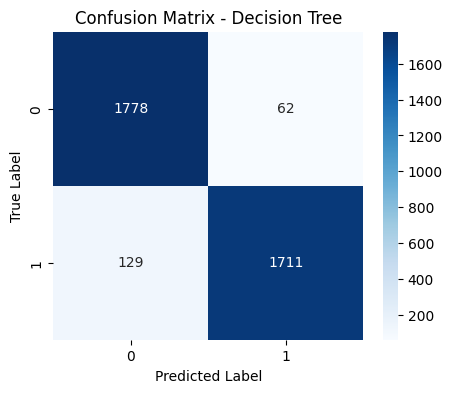


Training Random Forest...
Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Training Accuracy: 0.9997
Random Forest Testing Accuracy: 0.9565
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1840
           1       0.96      0.96      0.96      1840

    accuracy                           0.96      3680
   macro avg       0.96      0.96      0.96      3680
weighted avg       0.96      0.96      0.96      3680



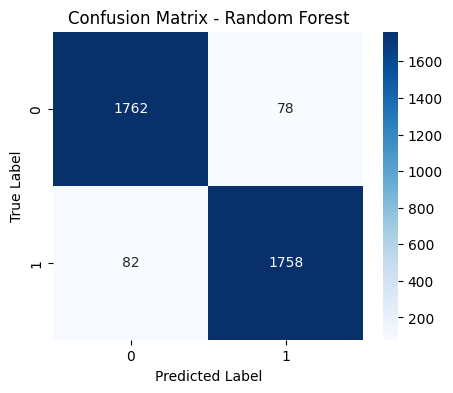


Training KNN...
KNN Best Params: {'n_neighbors': 9, 'weights': 'distance'}
KNN Training Accuracy: 1.0000
KNN Testing Accuracy: 0.9601
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1840
           1       0.97      0.95      0.96      1840

    accuracy                           0.96      3680
   macro avg       0.96      0.96      0.96      3680
weighted avg       0.96      0.96      0.96      3680



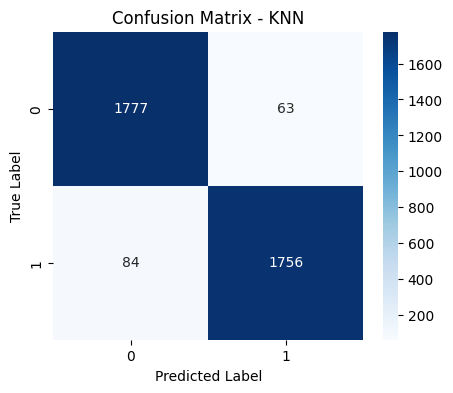


Training XGBoost...
XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
XGBoost Training Accuracy: 0.9723
XGBoost Testing Accuracy: 0.9543
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1840
           1       0.96      0.94      0.95      1840

    accuracy                           0.95      3680
   macro avg       0.95      0.95      0.95      3680
weighted avg       0.95      0.95      0.95      3680



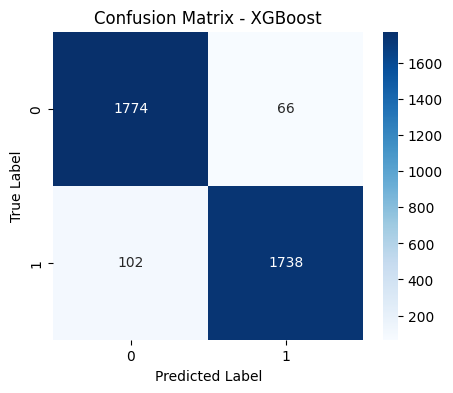


Training MLP...
MLP Best Params: {'hidden_layer_sizes': (256, 128), 'max_iter': 500}
MLP Training Accuracy: 0.9414
MLP Testing Accuracy: 0.9315
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1840
           1       0.95      0.92      0.93      1840

    accuracy                           0.93      3680
   macro avg       0.93      0.93      0.93      3680
weighted avg       0.93      0.93      0.93      3680



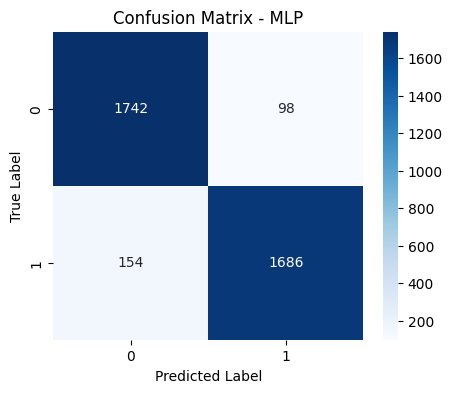


Model Performance Comparison(T-SNE + K-MEANS)
Decision Tree: Training Accuracy = 0.9691, Testing Accuracy = 0.9481
Random Forest: Training Accuracy = 0.9997, Testing Accuracy = 0.9565
KNN: Training Accuracy = 1.0000, Testing Accuracy = 0.9601
XGBoost: Training Accuracy = 0.9723, Testing Accuracy = 0.9543
MLP: Training Accuracy = 0.9414, Testing Accuracy = 0.9315


In [19]:
# Load t-SNE features
df_tsne = pd.read_csv("/content/EEG_TSNE_Features.csv")
print(df_tsne.head())

# Features and binary target
X = df_tsne.drop(columns=["Target"])
y = (df_tsne["Target"] != 0).astype(int)  # Binary: class 0 vs others

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter grids
dt_params = {'max_depth': [10, 15, 20], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 5]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [15, 20], 'min_samples_split': [2, 5]}
knn_params = {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']}
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 10]}
mlp_params = {'hidden_layer_sizes': [(128, 64), (256, 128)], 'max_iter': [500, 1000]}

# Initialize models
models = {
    "Decision Tree": GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, n_jobs=-1),
    "Random Forest": GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_jobs=-1),
    "KNN": GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, n_jobs=-1),
    "XGBoost": GridSearchCV(XGBClassifier(eval_metric='mlogloss', random_state=42), xgb_params, cv=3, n_jobs=-1),
    "MLP": GridSearchCV(MLPClassifier(activation='relu', solver='adam', random_state=42), mlp_params, cv=3, n_jobs=-1)
}

# Train and evaluate
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    best_model = model.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    results[name] = (train_acc, test_acc)

    print(f"{name} Best Params: {model.best_params_}")
    print(f"{name} Training Accuracy: {train_acc:.4f}")
    print(f"{name} Testing Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Final Summary
print("\nModel Performance Comparison(T-SNE + K-MEANS)")
for model, (train_acc, test_acc) in results.items():
    print(f"{model}: Training Accuracy = {train_acc:.4f}, Testing Accuracy = {test_acc:.4f}")